In [1]:
import pandas as pd
from collections import defaultdict, namedtuple
from pm4py.objects.petri.obj import PetriNet, Marking
from pm4py.objects.petri import utils
from pm4py.visualization.petri_net import visualizer as pn_visualizer


def run_alpha_plus_algorithm(traces):
    #Preprocessing phase
    # extracting the length 1 loops
    preprocess = True
    all_activities, start_activities, end_activities, direct_successions, length_two_loop, activities_with_loops = get_activities(traces, preprocess)
    footprint = FootPrintMatrix(activities_with_loops, direct_successions, length_two_loop)
    all_pairs = footprint.find_pairs()
    maximal_pairs = remove_non_maximal_pairs(all_pairs)
    loop_one_start, loop_one_end = filter_loop_one(maximal_pairs)
    remove_one_loops(traces)

    #Run Alpha Algorithm without length 1 loops
    preprocess = False
    tmp, tmp1, tmp2, direct_successions, length_two_loop, tmp3 = get_activities(traces, preprocess)
    footprint = FootPrintMatrix(tmp, direct_successions, length_two_loop)
    all_pairs = footprint.find_pairs()
    maximal_pairs = remove_non_maximal_pairs(all_pairs)

    #Add back length 1 loops
    net = AlphaPetriNet(start_activities=start_activities, end_activities=end_activities,
                        all_activities=all_activities, maximal_pairs=maximal_pairs, loop_one_start=loop_one_start, loop_one_end=loop_one_end)

    return net


def get_activities(traces, preprocess):
    """
    Get activity informations from traces.
    Returns set for all_activities, start_activities, end_activities and dict for direct_successions
    """
    start_activities = set()
    activities_with_loops = set()
    end_activities = set()
    all_activities = set()

    direct_successions = defaultdict(set)
    length_two_loop = defaultdict(set)

    # go through all our traces
    for trace in traces:

        # add start and end activities
        start_activities.add(trace[0])
        end_activities.add(trace[-1])

        # add activities of trace to all activities
        all_activities.update(trace)
        if preprocess:
            #remove duplicates at beginning and end
            remove_duplicates_beginning_and_end(trace)
            #remove triples
            remove_triples(trace)
            #detect length 1 loops
            tmp = trace.copy()
            for idx, activity in enumerate(tmp[1:], start=1):
                if tmp[idx-1] == tmp[idx] and tmp[idx] not in start_activities and tmp[idx] not in end_activities :
                    trace[idx] = "t" + trace[idx]
                    trace.pop(idx-1)

        # go through all activities in our trace and
        for idx, activity in enumerate(trace[1:], start=1):
            direct_successions[trace[idx - 1]].add(activity)

        # detect length 2 loops
        for idx, activity in enumerate(trace[2:], start=2):
            if trace[idx - 2] == activity and trace[idx - 1] != activity:
                length_two_loop[trace[idx - 2]].add(trace[idx - 1])
                #TODO check if right
                length_two_loop[trace[idx - 1]].add(trace[idx - 2])

        # add loops to activities
        activities_with_loops.update(trace)
    Activities = namedtuple("Activities", ["all_activities", "start_activities", "end_activities", "direct_successions", "length_two_loop", "activities_with_loops"])

    return Activities(all_activities, start_activities, end_activities, direct_successions, length_two_loop, activities_with_loops)
def remove_triples(trace):
    tmp = trace.copy()
    for i, act in enumerate(tmp[2:], start=2):
        if len(tmp)>2 and (tmp[i]==tmp[i-1]==tmp[i-2]):
            trace.pop(i)
def remove_duplicates_beginning_and_end(trace):
    if trace[0] == trace[1]:
        trace.pop(0)
        remove_duplicates_beginning_and_end(trace)
    elif trace[len(trace)-1] == trace[len(trace)-2]:
        trace.pop()
        remove_duplicates_beginning_and_end(trace)
    else:
        return trace
def filter_loop_one(max_pairs):
    loop_one_start = defaultdict(set)
    loop_one_end = defaultdict(set)
    # Add Input and Output Arcs for all our Pairs
    for idx, pair in enumerate(max_pairs, start=1):

        for a in pair[0]:
            if a.startswith("t"):
                for b in pair[1]:
                    loop_one_end[b].add(a[1:])
        for b in pair[1]:
            if b.startswith("t"):
                for a in pair[0]:
                    loop_one_start[a].add(b[1:])
    return loop_one_start, loop_one_end

def remove_one_loops(traces):
    for trace in traces:
        # go through all activities in our trace and
        for idx, activity in enumerate(trace[1:], start=1):
            if activity.startswith("t"):
                trace.remove(activity)

class FootPrintMatrix:
    footprint_df: pd.DataFrame = None

    def __init__(self, all_activities, direct_successions, length_two_loop):
        all_activities = sorted(list(all_activities))
        footprint = []

        for x in all_activities:
            row = []
            for y in all_activities:
                x_follows_y = x in direct_successions[y]
                y_follows_x = y in direct_successions[x]
                x_loop_y = y in length_two_loop[x]

                if y_follows_x and (not x_follows_y or x_loop_y):
                    row.append("→")
                elif x_follows_y and not y_follows_x:
                    row.append("←")
                elif x_follows_y and y_follows_x and not x_loop_y:
                    row.append("||")
                else:
                    row.append("#")
            footprint.append(row)

        self.footprint_df = pd.DataFrame(footprint, columns=all_activities, index=all_activities)

    def is_mergeable(self, p, q):
        """Check if two pairs are mergeable"""

        for pa in p[0]:
            # every activity in a must be #-(choice)-relation with every other element in a
            for qa in q[0]:
                if self.footprint_df[qa][pa] != "#":
                    return False

            # every activity in a must be in →-(causality)-relation with every activity in b
            for qb in q[1]:
                if self.footprint_df[qb][pa] != "→":
                    return False

        for pb in p[1]:
            # every activity in b must be #-(choice)-relation with every other element in b
            for qb in q[1]:
                if self.footprint_df[pb][qb] != "#":
                    return False

            # every activity in a must be in →-(causality)-relation with every activity in b
            for qa in q[0]:
                if self.footprint_df[pb][qa] != "→":
                    return False

        return True

    @staticmethod
    def merge_pairs(p, q):
        a = set(p[0])
        a.update(q[0])

        b = set(p[1])
        b.update(q[1])

        return (a, b)

    def find_pairs(self):
        # get all →-(causality)-relations
        pairs = [({self.footprint_df[col][self.footprint_df[col] == "→"].index[i]}, {col})
                 for col in self.footprint_df.columns for i in range(len(self.footprint_df[col][self.footprint_df[col] == '→'].index))]
        idx = 0
        while idx < len(pairs):
            p = pairs[idx]
            for q in pairs[idx + 1:]:
                # check if the pairs can be merged
                if self.is_mergeable(p, q):
                    # create and add the merged pair to pairs
                    merged_pair = self.merge_pairs(p, q)
                    if merged_pair not in pairs:
                        pairs.append(merged_pair)
            idx += 1
        return pairs


def remove_non_maximal_pairs(pairs):
    pairs = pairs.copy()
    idx = 0
    while idx < len(pairs) - 1:
        p = pairs[idx]
        non_max = False
        for q in pairs[idx+1:]:
            # check if current pair is a subset of another pair, if yes, remove pair
            if p[0].issubset(q[0]) and p[1].issubset(q[1]):
                pairs.pop(idx)
                non_max = True
                break
        if not non_max:
            idx += 1
    return pairs


class AlphaPetriNet:
    net: PetriNet = None
    initial_marking: Marking = None
    final_marking: Marking = None

    def __init__(self, start_activities, end_activities, all_activities, maximal_pairs, loop_one_start, loop_one_end):
        self.net = PetriNet("Example: Rehse")

        # create and add places
        source = PetriNet.Place("start")
        self.net.places.add(source)
        sink = PetriNet.Place("end")
        self.net.places.add(sink)

        # add tokens
        self.initial_marking = Marking()
        self.initial_marking[source] = 1
        self.final_marking = Marking()
        self.final_marking[sink] = 1

        # Add Transitions for all Activities
        transition_map = {}
        for activity in all_activities:
            transition = PetriNet.Transition(activity, activity)
            self.net.transitions.add(transition)
            transition_map[activity] = transition

        # Add Input Arc from Start Place (Source) to Start Activities/Transitions
        for activity in start_activities:
            utils.add_arc_from_to(source, transition_map[activity], self.net)

        # Add Output Arc from End Activities/Transitions to End Place (Sink)
        for activity in end_activities:
            utils.add_arc_from_to(transition_map[activity], sink, self.net)

        # Add Input and Output Arcs for all our Pairs
        for idx, pair in enumerate(maximal_pairs, start=1):
            place = PetriNet.Place("p%d" % idx)
            self.net.places.add(place)

            for a in pair[0]:
                utils.add_arc_from_to(transition_map[a], place, self.net)
                if a in loop_one_start:
                    for idx in loop_one_start[a]:
                        utils.add_arc_from_to(transition_map[idx], place, self.net)
            for b in pair[1]:
                utils.add_arc_from_to(place, transition_map[b], self.net)
                if b in loop_one_end:
                    for idx in loop_one_end[b]:
                        utils.add_arc_from_to(place, transition_map[idx], self.net)


    def show(self):
        gviz = pn_visualizer.apply(self.net, self.initial_marking, self.final_marking)
        pn_visualizer.view(gviz)

/Users/alexandergerhold/opt/anaconda3/envs/py35/lib/python3.7/site-packages/pm4py/objects/petri/__init__.py:19: UserWarning: please use the pm4py.objects.petri_net package instead.
  warnings.warn('please use the pm4py.objects.petri_net package instead.')
/Users/alexandergerhold/opt/anaconda3/envs/py35/lib/python3.7/site-packages/pm4py/objects/petri/obj.py:19: UserWarning: pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.
  warnings.warn("pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.")
/Users/alexandergerhold/opt/anaconda3/envs/py35/lib/python3.7/site-packages/pm4py/objects/petri/exporter/__init__.py:21: UserWarning: please use the pm4py.objects.petri_net.exporter package instead.
  warnings.warn('please use the pm4py.objects.petri_net.exporter package instead.')
/Users/alexandergerhold/opt/anaconda3/envs/py35/lib/python3.7/site-packages/pm4py/objects/petri/importer/__init__.py:21: UserWar

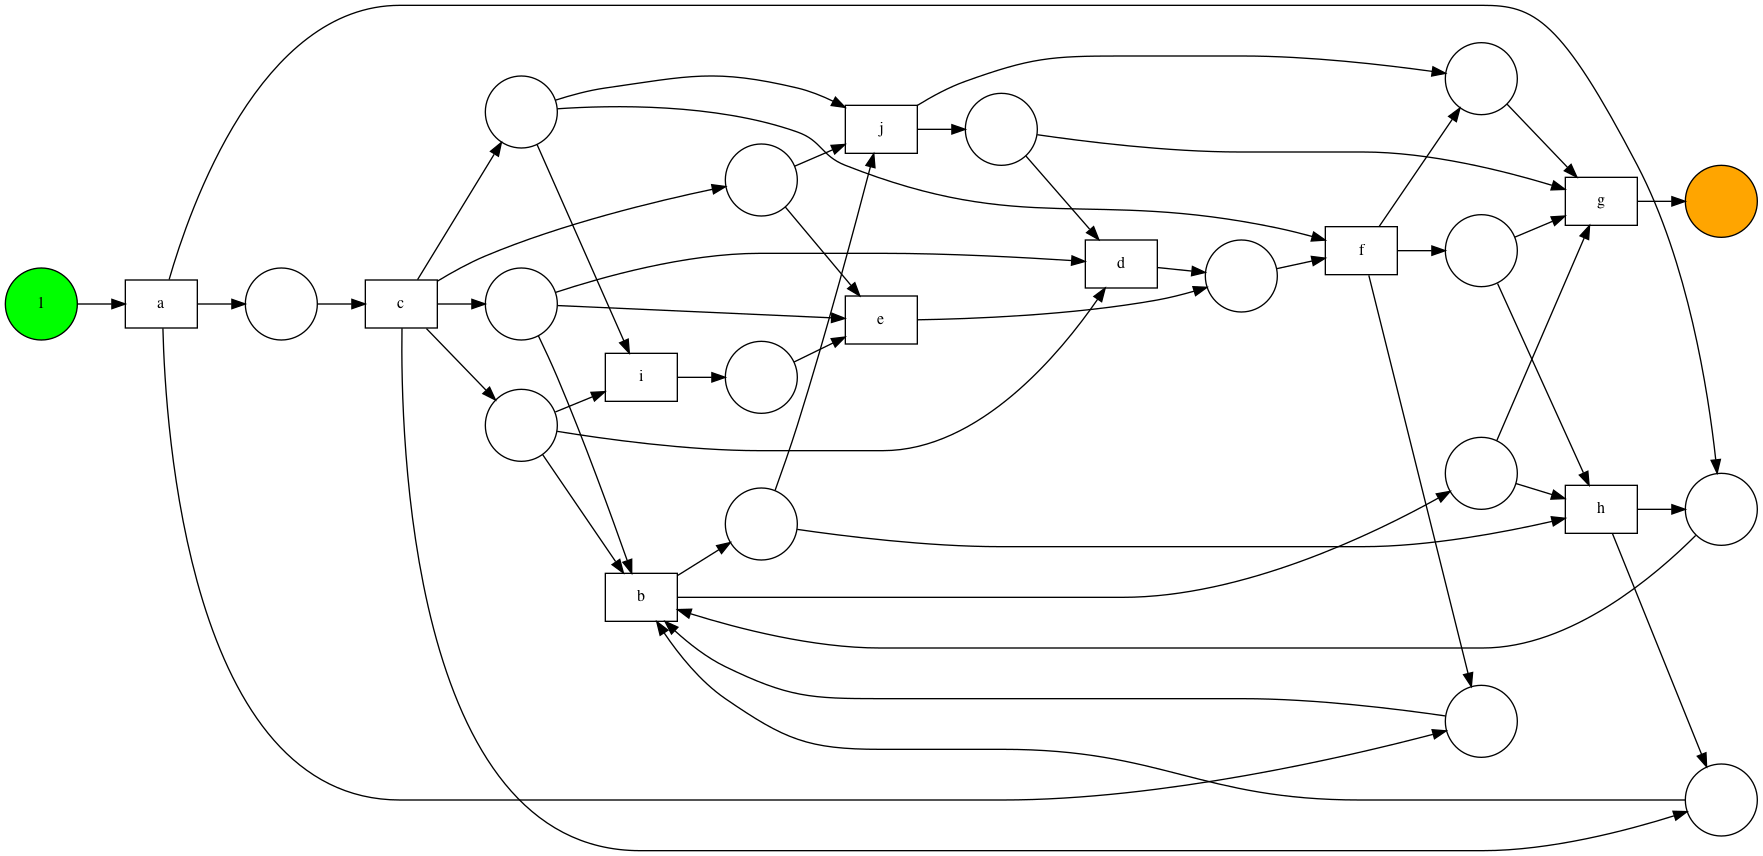

In [18]:
import pandas as pd
from collections import defaultdict
#from alpha_algorithm import run_alpha_algorithm
#from alpha_plus_algorithm import run_alpha_plus_algorithm
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
# aalst traces
#traces = [
#    ["a", "b", "c", "d"],
#    ["a", "c", "b", "d"],
#    ["a", "e", "d"]
#]

# rehse traces
traces = [
    ["a", "c", "d", "e"],
    ["b", "c", "d", "e"],
    ["a", "c", "e", "d"],
    ["b", "c", "e", "d"],
    ["a", "c", "d", "a", "d"]
]
traces2 = [
    ["a", "a","a", "c", "a", "a", "c", "d", "e", "e", "e"],
    ["b", "c", "e", "d"],
    ["a", "c", "e", "e", "e", "d"],
    ["b", "c", "c", "e", "d"],
    ["a", "c", "a", "d"],
    ["a", "j", "j", "d"]
]

traces3 = [
    ["a", "b", "a", "e", "e",  "c"]
]

net = run_alpha_plus_algorithm(traces_all)

net.show()

In [3]:
data=pd.read_excel('/Users/alexandergerhold/Desktop/MMDS/FSS21/Advanced Process Mining/Traces_Example.xlsx')

In [4]:
display(data)

,Traces
0,"a,c,e,f,g"
1,"a,c,e,f,g"
2,"a,c,e,f,g"
3,"a,c,e,f,g"
4,"a,c,e,f,g"
...,...
93,"a,c,i,i,i,i,i,f,h,b,g"
94,"a,c,i,i,i,i,i,f,h,b,g"
95,"a,c,i,i,i,i,i,f,h,b,g"
96,"a,c,j,d,f,g"


In [6]:
def dataprep(data):
    traces_all=[]
    for index,Traces in data.iterrows():
        a=[]
        sp=[]
        a.append(data["Traces"].values[index])
        sp=a[0].split(',')
        traces_all.append(sp)
    return (traces_all)

In [8]:
print(traces_all)

[['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'e', 'f', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e', 'f', 'b', 'g'], ['a', 'c', 'i', 'i', 'e'